
# 2D ERT modeling and inversion


In [2]:
import matplotlib.pyplot as plt
import numpy as np

import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics import ert

## Geometry definition
Create geometry definition for the modelling domain. ``worldMarker=True``
indicates the default boundary conditions for the ERT



In [3]:
world = mt.createWorld(start=[-50, 0], end=[50, -50], layers=[-1, -5],
                       worldMarker=True)

Create some heterogeneous circular anomaly



In [4]:
block = mt.createCircle(pos=[-5, -3.], radius=[4, 1], marker=4,
                        boundaryMarker=10, area=0.1)

In [5]:
poly = mt.createPolygon([(1,-4), (2,-1.5), (4,-2), (5,-2),
                         (8,-3), (5,-3.5), (3,-4.5)], isClosed=True,
                         addNodes=3, interpolate='spline', marker=5)

Merge geometry definition into a Piecewise Linear Complex (PLC)



In [6]:
geom = world + block + poly

Optional: show the geometry



(<Axes: >, None)

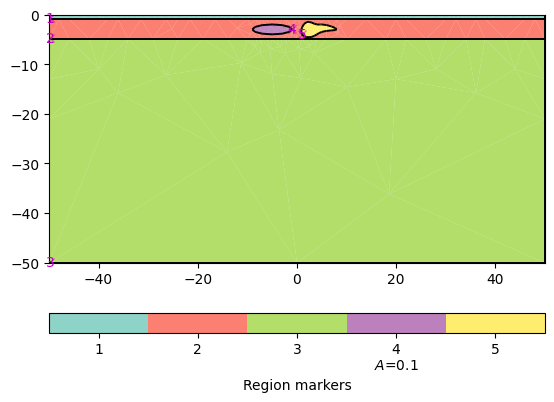

In [7]:
pg.show(geom)

## Synthetic data generation
Create a Dipole Dipole ('dd') measuring scheme with 21 electrodes.



In [8]:
scheme = ert.createData(elecs=np.linspace(start=-15, stop=15, num=21),
                           schemeName='dd')

Put all electrode (aka sensors) positions into the PLC to enforce mesh
refinement. Due to experience, its convenient to add further refinement
nodes in a distance of 10% of electrode spacing to achieve sufficient
numerical accuracy.



(<Axes: >, <matplotlib.colorbar.Colorbar at 0x7f87d58cdd80>)

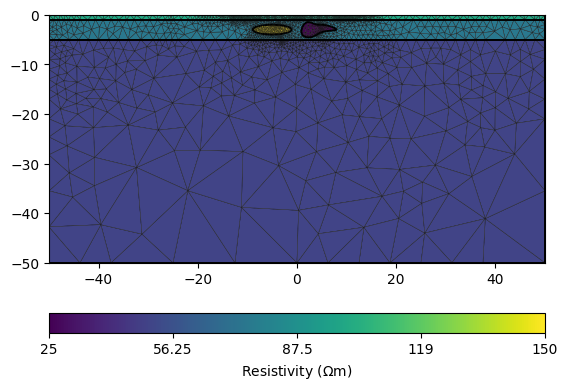

In [9]:
for p in scheme.sensors():
    geom.createNode(p)
    geom.createNode(p - [0, 0.1])

# Create a mesh for the finite element modelling with appropriate mesh quality.
mesh = mt.createMesh(geom, quality=34)

# Create a map to set resistivity values in the appropriate regions
# [[regionNumber, resistivity], [regionNumber, resistivity], [...]
rhomap = [[1, 100.],
          [2, 75.],
          [3, 50.],
          [4, 150.],
          [5, 25]]

# Take a look at the mesh and the resistivity distribution
pg.show(mesh, data=rhomap, label=pg.unit('res'), showMesh=True)

Perform the modeling with the mesh and the measuring scheme itself
and return a data container with apparent resistivity values,
geometric factors and estimated data errors specified by the noise setting.
The noise is also added to the data. Here 1% plus 1µV.
Note, we force a specific noise seed as we want reproducable results for
testing purposes.



In [10]:
data = ert.simulate(mesh, scheme=scheme, res=rhomap, noiseLevel=1,
                    noiseAbs=1e-6, seed=1337)

pg.info(np.linalg.norm(data['err']), np.linalg.norm(data['rhoa']))
pg.info('Simulated data', data)
pg.info('The data contains:', data.dataMap().keys())

pg.info('Simulated rhoa (min/max)', min(data['rhoa']), max(data['rhoa']))
pg.info('Selected data noise %(min/max)', min(data['err'])*100, max(data['err'])*100)

ModellingBase::setMesh() copying new mesh ... Found datafile: 21 electrodes
Found: 21 free-electrodes
rMin = 0.75, rMax = 60
NGauLeg + NGauLag for inverse Fouriertransformation: 11 + 4
Found non-Neumann domain
0.0335749 s
FOP updating mesh dependencies ... 2.1e-06 s


07/09/23 - 18:17:43 - pyGIMLi - INFO - 0.13172095457607066 956.0725038881353
07/09/23 - 18:17:43 - pyGIMLi - INFO - Simulated data Data: Sensors: 21 data: 171, nonzero entries: ['a', 'b', 'err', 'k', 'm', 'n', 'rhoa', 'valid']
07/09/23 - 18:17:43 - pyGIMLi - INFO - The data contains: ['a', 'b', 'err', 'i', 'ip', 'iperr', 'k', 'm', 'n', 'r', 'rhoa', 'u', 'valid']
07/09/23 - 18:17:43 - pyGIMLi - INFO - Simulated rhoa (min/max) 42.792496044211 104.19891011722967
07/09/23 - 18:17:43 - pyGIMLi - INFO - Selected data noise %(min/max) 1.0000294838286121 1.056761917552525


relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100
Data error estimate (min:max)  0.010000294838286121 : 0.01056761917552525
Calculating response for model: min = 25 max = 150
Allocating memory for primary potential...... 0.0014425

No primary potential for secondary field calculation. Calculating analytically...
Forward: time: 0.288855s
Response: min = 43.6475 max = 102.718 mean = 71.3742
Reciprocity rms(modelReciprocity) 0.140597%, max: 0.449979%


Optional: you can filter all values and tokens in the data container.
Its possible that there are some negative data values due to noise and
huge geometric factors. So we need to remove them.



07/09/23 - 18:17:43 - pyGIMLi - INFO - Filtered rhoa (min/max) 42.792496044211 104.19891011722967


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x7f87d56fc9d0>)

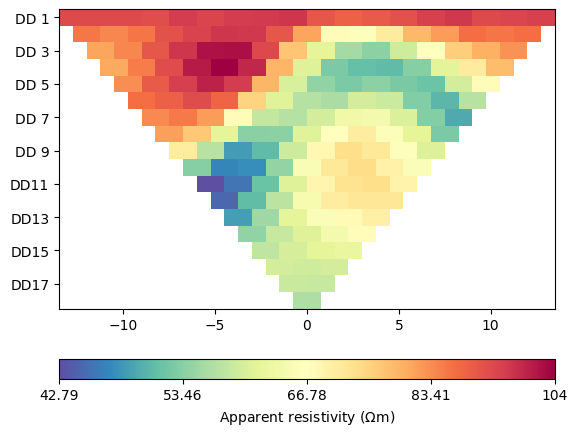

In [11]:
data.remove(data['rhoa'] < 0)
pg.info('Filtered rhoa (min/max)', min(data['rhoa']), max(data['rhoa']))

# You can save the data for further use
data.save('simple.dat')

# You can take a look at the data
ert.show(data)

## Inversion with the ERTManager
Initialize the ERTManager, e.g. with a data container or a filename.



In [12]:
mgr = ert.ERTManager('simple.dat')

Run the inversion with the preset data. The Inversion mesh will be created
with default settings.



In [13]:
inv = mgr.invert(lam=20, verbose=True)
np.testing.assert_approx_equal(mgr.inv.chi2(), 0.7, significant=1)

07/09/23 - 18:17:43 - pyGIMLi - INFO - Found 2 regions.
07/09/23 - 18:17:43 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
07/09/23 - 18:17:43 - pyGIMLi - INFO - Found 2 regions.
07/09/23 - 18:17:43 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
07/09/23 - 18:17:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
07/09/23 - 18:17:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
07/09/23 - 18:17:43 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 987 Cells: 1824 Boundaries: 1442
07/09/23 - 18:17:43 - pyGIMLi - INFO - Use median(data values)=67.9439561191829
07/09/23 - 18:17:43 - pyGIMLi - INFO - Created startmodel from forward operator: 287 [67.9439561191829,...,67.9439561191829]
07/09/23 - 18:17:43 - pyGIMLi - INFO - Starting inversion.


Constructing Delaunay triangulation by divide-and-conquer method.
Delaunay milliseconds:  0
Recovering segments in Delaunay triangulation.
Segment milliseconds:  0
Removing unwanted triangles.
Spreading regional attributes and area constraints.
Hole milliseconds:  0
Adding Steiner points to enforce quality.
Quality milliseconds:  0

Writing vertices.
Writing triangles.
Writing segments.
Writing edges.

Output milliseconds:  0
Total running milliseconds:  0

Statistics:

  Input vertices: 49
  Input segments: 50
  Input holes: 0

  Mesh vertices: 266
  Mesh triangles: 456
  Mesh edges: 721
  Mesh exterior boundary edges: 74
  Mesh interior boundary edges: 15
  Mesh subsegments (constrained edges): 89

min/max(dweight) = 94.6287/99.9971
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x7f87d5750ea0>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x7f87d577c810>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x7f87d5750c70>
min/max (data): 42.79/10

1: LS newModel: min = chi² = 14.2 (dPhi = 97.01%) lam: 20
--------------------------------------------------------------------------------
inv.iter 2 ... 16.2821; max = 137.406
1: LS newResponse: min = 37.6023; max = 103.941
1: rms/rrms(data, LS newResponse) = 3.08168/5.45237%
1: chi^2(data, LS newResponse, error, log) = 31.8367
1: Phi = 5444.07+10.8288*20=5660.65
Linesearch tau = 0.86
Calculating response for model: min = 19.8871 max = 124.505
Using existing primary potentials.
Forward: time: 0.178045s
Response: min = 41.6458 max = 97.8126 mean = 68.9631
Reciprocity rms(modelReciprocity) 0.292384%, max: 1.06264%
1: Model: min = 19.8871; max = 124.505
1: Response: min = 41.5097; max = 97.9775
1: rms/rrms(data, Response) = 2.87691/3.70588%
1: chi^2(data, Response, error, log) = 14.2048
1: Phi = 2429.02+8.00895*20=2589.2
calculating jacobian matrix (forced=1)...Using existing subpotentials for createJacobian.
S(8/8-std::mt): 0.0001386:time: 0.0828678s
sens sum: median = 1.14152 min = 0.9

Let the ERTManger show you the model of the last successful run and how it
fits the data. Shows data, model response, and model.



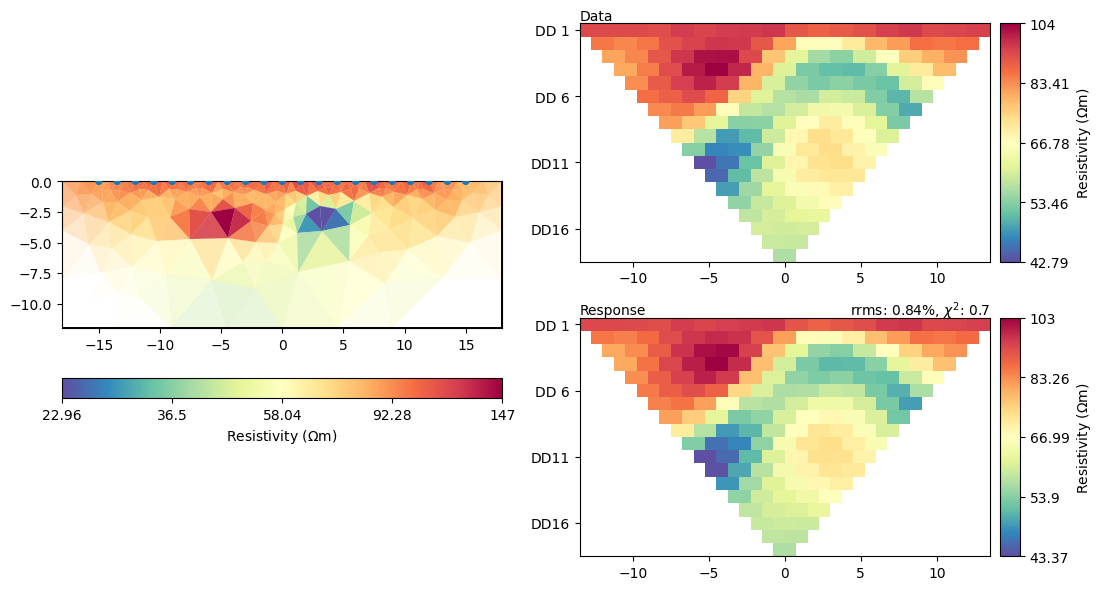

In [14]:
mgr.showResultAndFit()
meshPD = pg.Mesh(mgr.paraDomain) # Save copy of para mesh for plotting later

You can also provide your own mesh (e.g., a structured grid if you like them)
Note, that x and y coordinates needs to be in ascending order to ensure that
all the cells in the grid have the correct orientation, i.e., all cells need
to be numbered counter-clockwise and the boundary normal directions need to
point outside.



In [15]:
inversionDomain = pg.createGrid(x=np.linspace(start=-18, stop=18, num=33),
                                y=-pg.cat([0], pg.utils.grange(0.5, 8, n=5))[::-1],
                                marker=2)

## Inversion with custom mesh
The inversion domain for ERT problems needs a boundary that represents the
far regions in the subsurface of the halfspace.
Give a cell marker lower than the marker for the inversion region, the lowest
cell marker in the mesh will be the inversion boundary region by default.



(<Axes: >, <matplotlib.colorbar.Colorbar at 0x7f87d42e4ac0>)

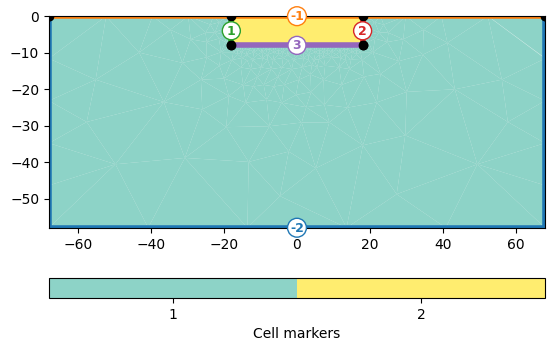

In [16]:
grid = pg.meshtools.appendTriangleBoundary(inversionDomain, marker=1,
                                           xbound=50, ybound=50)
pg.show(grid, markers=True)

The Inversion can be called with data and mesh as argument as well



In [17]:
model = mgr.invert(data, mesh=grid, lam=20, verbose=True)
np.testing.assert_approx_equal(mgr.inv.chi2(), 1.4, significant=2)

07/09/23 - 18:17:46 - pyGIMLi - INFO - Found 2 regions.
07/09/23 - 18:17:46 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
07/09/23 - 18:17:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
07/09/23 - 18:17:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
07/09/23 - 18:17:46 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 1462 Cells: 2164 Boundaries: 1842
07/09/23 - 18:17:46 - pyGIMLi - INFO - Use median(data values)=67.9439561191829
07/09/23 - 18:17:46 - pyGIMLi - INFO - Created startmodel from forward operator: 160 [67.9439561191829,...,67.9439561191829]
07/09/23 - 18:17:46 - pyGIMLi - INFO - Starting inversion.


Found datafile: 21 electrodes
Found: 21 node-electrodes
Found non-Neumann domain
 updateDataDependency:: cleaning primpot
Reset region parameter
RegionManager copying mesh ...0.0033432 s 
create NeighborInfos ... 3.05e-05 s 
analysing mesh ... 2 regions.
creating para domain ... 0.0010222 s
creating para domain ... 0.0015606 s
ModellingBase::setMesh() copying new mesh ... Found datafile: 21 electrodes
Found: 21 free-electrodes
Found non-Neumann domain
0.0121769 s
FOP updating mesh dependencies ... 1.35e-05 s
ModellingBase::setMesh() copying new mesh ... 0.0201281 s
FOP updating mesh dependencies ... 2.74e-05 s
min/max(dweight) = 94.6287/99.9971
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x7f87d5750ea0>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x7f87d577c810>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x7f87d5750c70>
min/max (data): 42.79/104
min/max (error): 1%/1.06%
min/max (start model): 67.94/67.94
-----------------------------

## Visualization
You can of course get access to mesh and model and plot them for your own.
Note that the cells of the parametric domain of your mesh might be in
a different order than the values in the model array if regions are used.
The manager can help to permutate them into the right order.



07/09/23 - 18:17:49 - pyGIMLi - INFO - Inversion stopped with chi² = 1.42


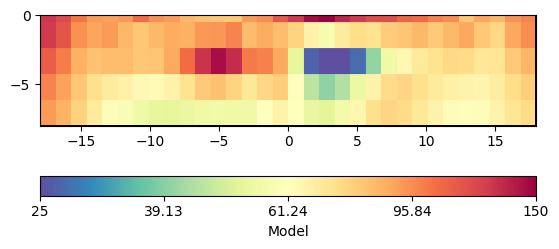

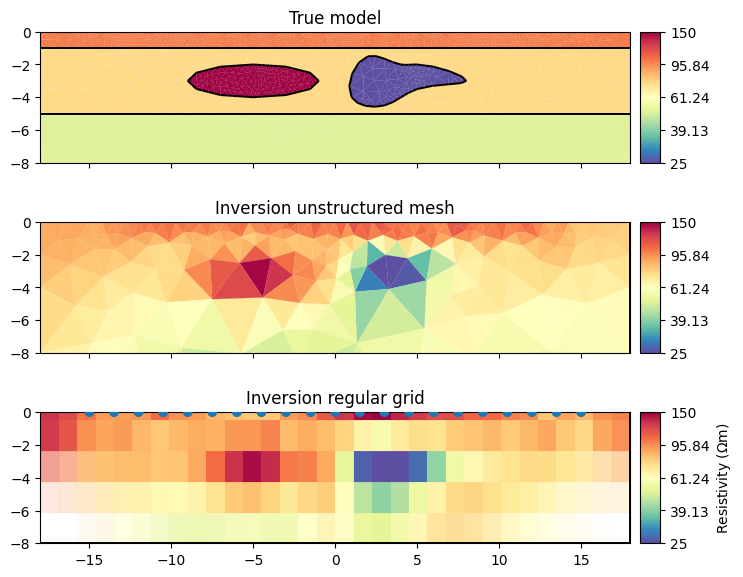

In [18]:
modelPD = mgr.paraModel(model)  # do the mapping
pg.show(mgr.paraDomain, modelPD, label='Model', cMap='Spectral_r',
        logScale=True, cMin=25, cMax=150)

pg.info('Inversion stopped with chi² = {0:.3}'.format(mgr.fw.chi2()))

fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, sharey=True, figsize=(8,7))

pg.show(mesh, rhomap, ax=ax1, hold=True, cMap="Spectral_r", logScale=True,
        orientation="vertical", cMin=25, cMax=150)
pg.show(meshPD, inv, ax=ax2, hold=True, cMap="Spectral_r", logScale=True,
        orientation="vertical", cMin=25, cMax=150)
mgr.showResult(ax=ax3, cMin=25, cMax=150, orientation="vertical")

labels = ["True model", "Inversion unstructured mesh", "Inversion regular grid"]
for ax, label in zip([ax1, ax2, ax3], labels):
    ax.set_xlim(mgr.paraDomain.xmin(), mgr.paraDomain.xmax())
    ax.set_ylim(mgr.paraDomain.ymin(), mgr.paraDomain.ymax())
    ax.set_title(label)